<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/temp_hosting/ML_classifier_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [1]:
!pip install vecstack==0.4.0 -q
#!pip install yfinance==0.2.28 -q
#!pip install -U scikit-learn==1.0

  Preparing metadata (setup.py) ... done


In [2]:
!pip install pandas-ta -q
#==0.2.45b

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier
from vecstack import stacking
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from pandas_datareader import data as pdr
START = '2020-01-01' #yyyy-mm-dd
END = '2023-10-01' #2022-05-13 #2022-05-02
START_testing='2023-10-03'

In [4]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=18
days_out=18
dictionary_bull={True:1, False:1}#{True:0.75, False:0.5}
dictionary_bear ={True:1,False:1}# {True:3,False:0.5}

In [5]:
def calculate_technical_indicators(df, fast_macd=12, slow_macd=26, signal_macd=9, vortex_length=8, aroon_length=8, rsi_length=8):
    """
    Calculates and appends technical indicators to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        fast_macd (int, optional): Fast period for MACD. Defaults to 12.
        slow_macd (int, optional): Slow period for MACD. Defaults to 26.
        signal_macd (int, optional): Signal period for MACD. Defaults to 9.
        vortex_length (int, optional): Length for Vortex indicator. Defaults to 18.
        aroon_length (int, optional): Length for Aroon indicator. Defaults to 18.
        rsi_length (int, optional): Length for RSI indicator. Defaults to 18.

    Returns:
        pd.DataFrame: The DataFrame with the calculated indicators appended.
    """
    for t in [0.5,0.75,1,1.2]:

      df.ta.macd(fast=fast_macd, slow=slow_macd, signal=signal_macd, append=True)
      df.ta.macd(fast=int(fast_macd * t), slow=int(slow_macd * t), signal=int(signal_macd * t), append=True)
      df.ta.vortex(length=vortex_length, append=True)
      df.ta.aroon(length=aroon_length, append=True)
      df.ta.rsi(length=rsi_length, append=True)
      df.ta.vortex(length=int(vortex_length * t), append=True)
      df.ta.aroon(length=int(aroon_length * t), append=True)
      df.ta.rsi(length=int(rsi_length * t), append=True)
    return df

# Prepare data

In [6]:
import pandas as pd
import yfinance as yf

def get_equal_weighted_index(tickers, var, start_date, end_date):
    """
    Calculates the equal-weighted index for a list of tickers over a specified period.

    Args:
        tickers (list): List of ticker symbols.
        var (str): Variable to use for calculation (e.g., "Close", "Open"). Default is "Close".
        start_date (str): Start date for data retrieval (YYYY-MM-DD).
        end_date (str): End date for data retrieval (YYYY-MM-DD).

    Returns:
        float: The final value of the equal-weighted index.
    """



    # Download historical data
    data = yf.download(tickers, start=start_date, end=end_date)[var]

    # Calculate percentage returns
    returns = data.pct_change()
    weights = [1 / len(tickers)] * len(tickers)
     # Calculate index value
    index_value = 100  # Initial index value
    index_returns = returns.mul(weights).sum(axis=1)
    index_value = (1 + index_returns).cumprod() * index_value

    return index_value


In [7]:
def get_equal_weighted_index_test(tickers, var, start_date):
    """
    Calculates the equal-weighted index for a list of tickers over a specified period.

    Args:
        tickers (list): List of ticker symbols.
        var (str): Variable to use for calculation (e.g., "Close", "Open"). Default is "Close".
        start_date (str): Start date for data retrieval (YYYY-MM-DD).
        end_date (str): End date for data retrieval (YYYY-MM-DD).

    Returns:
        float: The final value of the equal-weighted index.
    """



    # Download historical data
    data = yf.download(tickers, start=start_date)[var]

    # Calculate percentage returns
    returns = data.pct_change()
    weights = [1 / len(tickers)] * len(tickers)
     # Calculate index value
    index_value = 100  # Initial index value
    index_returns = returns.mul(weights).sum(axis=1)
    index_value = (1 + index_returns).cumprod() * index_value

    return index_value


In [8]:

tker = ['ASTRAL.NS', 'FINPIPE.NS', 'PRINCEPIPE.NS', 'SUPREMEIND.NS']

var='Close'
nifty_close = get_equal_weighted_index(tker,var, START, END)
var='Open'
nifty_open = get_equal_weighted_index(tker,var, START, END)
var='High'
nifty_high = get_equal_weighted_index(tker,var, START, END)
var='Low'
nifty_low = get_equal_weighted_index(tker,var, START, END)




[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [9]:
nifty=pd.concat([nifty_open,nifty_high,nifty_low,nifty_close],axis=1)


In [10]:
nifty.columns=["Open","High","Low","Close"]

<Axes: xlabel='Date'>

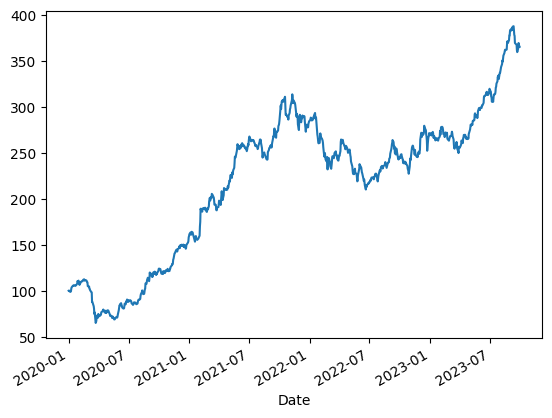

In [11]:
nifty.Close.plot()

In [12]:
nifty=calculate_technical_indicators(nifty)


In [13]:
df_old = nifty.copy()
# I Just need the Close
price_data = df_old.copy()

In [14]:
features = price_data.columns.tolist()

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [15]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups

# Calculate the conditions separately
condition1 = price_data['MACDh_12_26_9'] > price_data['MACDh_12_26_9'].shift()
condition2 = price_data['ADV_13'] > price_data['ADV_13'].shift()

# Create the Strength_Flag_dummy column
price_data['Strength_Flag_dummy'] = condition1 & condition2


In [16]:
#price_data=price_data.assign(Strength_Flag_dummy=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift())))

In [17]:
#price_data=price_data.assign(Strength_Flag_dum=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))

In [18]:
price_data.dropna(inplace=True)

In [19]:
#price_data.Strength_Flag_dummy.value_counts()

In [20]:
#price_data.Strength_Flag_dummy = price_data.Strength_Flag_dummy.replace(dictionary_bull)

In [21]:
#price_data.Strength_Flag_dum.value_counts()

In [22]:
#price_data.Strength_Flag_dum = price_data.Strength_Flag_dum.replace(dictionary_bear)

In [23]:
#price_data['Strength_Flag']=price_data.Strength_Flag_dum+price_data.Strength_Flag_dummy

In [24]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

# Initialize 1st level models

In [25]:
#sample_w=price_data[:samp_train].Strength_Flag.values

In [26]:
models_L1 = [
    LogisticRegression(max_iter=12000),
    svm.SVC(kernel='linear'),
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),

    RandomForestClassifier(random_state=0, n_jobs=-1,
                           n_estimators=500, max_depth=3,class_weight='balanced'),

    LDA(solver='svd', shrinkage=None, priors=None, n_components=None,
        store_covariance=False, tol=0.0001, covariance_estimator=None),

]

In [27]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [28]:
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train, y_train)#sample_weight=sample_w
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train)#,sample_weight=sample_w
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train)
# save model in file if you need
model_L1_4 = models_L1[4]
_ = model_L1_4.fit(X_train, y_train)
# save model in file if you need

# save model in file if you need



In [29]:
model_L1_3.feature_importances_

array([3.49828559e-03, 2.40077909e-03, 3.47294299e-03, 2.82641970e-03,
       7.49964438e-02, 1.50452409e-02, 3.39407692e-02, 1.14611467e-01,
       4.65425976e-03, 1.87545706e-01, 1.47841115e-03, 4.74662906e-03,
       9.45974625e-04, 3.61810530e-03, 6.57452756e-03, 5.85653995e-02,
       1.87256183e-03, 1.04362161e-03, 4.80863318e-04, 4.66135837e-05,
       7.36028813e-04, 3.98261806e-03, 1.33790197e-01, 3.73933800e-03,
       1.11736096e-01, 1.46227060e-03, 1.84306938e-03, 6.06055237e-04,
       2.38624244e-04, 5.04804887e-04, 2.87394554e-02, 4.08010518e-02,
       3.20599538e-02, 1.48701012e-02, 1.24498671e-03, 9.15390838e-03,
       1.21267345e-03, 1.27927636e-02, 8.32842498e-03, 6.97925568e-02])

In [30]:
importances = model_L1_3.feature_importances_
data = {'feature_name': features, 'importance': importances*100}
df = pd.DataFrame(data)

In [31]:
df = df.sort_values(by='importance')
print(df)

      feature_name  importance
19        AROONU_4    0.004661
28        AROONU_6    0.023862
18        AROOND_4    0.048086
29      AROONOSC_6    0.050480
27        AROOND_6    0.060606
20      AROONOSC_4    0.073603
12        AROOND_8    0.094597
17          VTXM_4    0.104362
36        AROOND_9    0.121267
34          VTXP_9    0.124499
25          VTXP_6    0.146227
10          VTXP_8    0.147841
26          VTXM_6    0.184307
16          VTXP_4    0.187256
1             High    0.240078
3            Close    0.282642
2              Low    0.347294
0             Open    0.349829
13        AROONU_8    0.361811
23    MACDh_9_19_6    0.373934
21           RSI_4    0.398262
8     MACDh_6_13_4    0.465426
11          VTXM_8    0.474663
14      AROONOSC_8    0.657453
38      AROONOSC_9    0.832842
35          VTXM_9    0.915391
37        AROONU_9    1.279276
33  MACDs_14_31_10    1.487010
5    MACDh_12_26_9    1.504524
30           RSI_6    2.873946
32  MACDh_14_31_10    3.205995
6    MAC

# Perform stacking

In [32]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need
                                                       #     probabilities - set to True)
                           save_dir=None,              # do not save result and log (to save
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [5]

model  0:     [LogisticRegression]
    fold  0:  [0.93006993]
    fold  1:  [0.81690141]
    fold  2:  [0.84507042]
    fold  3:  [0.83802817]
    ----
    MEAN:     [0.85751748] + [0.04315173]
    FULL:     [0.85764499]

model  1:     [SVC]
    fold  0:  [0.93706294]
    fold  1:  [0.80985915]
    fold  2:  [0.83802817]
    fold  3:  [0.76760563]
    ----
    MEAN:     [0.83813897] + [0.06237119]
    FULL:     [0.83831283]

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.90209790]
    fold  1:  [0.73943662]
    fold  2:  [0.84507042]
    fold  3:  [0.71830986]
    ----
    MEAN:     [0.80122870] + [0.07548259]
    FULL:     [0.80140598]

model  3:     [RandomForestClassifier]
    fold  0:  [0.90209790]
    fold  1:  [0.74647887]
    fold  2:  [0.81690141]
    fold  3:  [0.58450704]
    ----
    MEAN:     [0.76249631] + [0.11660323]
    FULL:     [0.76274165]

mo

# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [33]:
# XGboost
model_L1_X = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Fit 2nd level model
dummy_train = model_L1_X.fit(X_train,y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

# Apply 2nd level model

In [34]:
'''
# Initialize 2nd level model
model_L2 = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
S_train=np.c_[S_train,dummy_train]
# Fit 2nd level model
_ = model_L2.fit(S_train,y_train)
# Predict
y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
'''

"\n# Initialize 2nd level model\nmodel_L2 = XGBClassifier(learning_rate =0.1,\n n_estimators=100,\n max_depth=3,\n min_child_weight=1,\n gamma=0,\n reg_alpha= 0.01,\n subsample=0.75,\n colsample_bytree=0.75,\n objective= 'binary:logistic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\nS_train=np.c_[S_train,dummy_train]\n# Fit 2nd level model\n_ = model_L2.fit(S_train,y_train)\n# Predict\ny_pred = model_L2.predict(S_test)\n\n# Final prediction score\n#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))\n"

# Make Predictions

In [35]:

#tker = ['APARINDS.NS', 'UCOBANK.NS', 'MAZDOCK.NS', 'CIEINDIA.NS', 'FACT.NS', 'JINDALSAW.NS', 'JSL.NS', 'SAFARI.NS', 'VBL.NS', 'PNBHOUSING.NS']

var='Close'
nifty_close = get_equal_weighted_index_test(tker,var, START_testing)
var='Open'
nifty_open = get_equal_weighted_index_test(tker,var, START_testing)
var='High'
nifty_high = get_equal_weighted_index_test(tker,var, START_testing)
var='Low'
nifty_low = get_equal_weighted_index_test(tker,var, START_testing)



[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [36]:
nifty_test=pd.concat([nifty_open,nifty_high,nifty_low,nifty_close],axis=1)

nifty_test.columns=["Open","High","Low","Close"]

nifty_test=calculate_technical_indicators(nifty_test)

In [37]:
price_data_new =nifty_test.copy()
df=nifty_test.copy()
price_data_new.tail(2)

,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_6_13_4,MACDh_6_13_4,MACDs_6_13_4,...,RSI_6,MACD_14_31_10,MACDh_14_31_10,MACDs_14_31_10,VTXP_9,VTXM_9,AROOND_9,AROONU_9,AROONOSC_9,RSI_9
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-05 00:00:00+00:00,113.918194,113.390218,113.232442,113.912894,-1.658215,0.419780,-2.077995,-0.381982,-0.084923,-0.297060,...,36.442335,-2.125234,0.405321,-2.530555,0.527929,0.678769,88.888889,44.444444,-44.444444,38.404387
2024-09-06 00:00:00+00:00,113.358031,114.380135,112.682189,113.756576,-1.628575,0.359536,-1.988111,-0.450374,-0.091988,-0.358385,...,34.882912,-2.086474,0.363339,-2.449813,0.566152,0.595610,100.000000,33.333333,-66.666667,37.489319


In [38]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_test_new =price_data_new[features]
#Y_Cols = price_data_new['Prediction']




In [39]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):
y_pred_L1_0 = model_L1_0.predict(X_test_new)
y_pred_L1_1 = model_L1_1.predict(X_test_new)
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
y_pred_L1_4 = model_L1_4.predict(X_test_new)

#y_pred_l1_6= model_L1_X.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

#y_pred_new = model_L2.predict(S_test_new)


In [40]:
S_test_new[-5:]#.sum(axis=1)

array([[-1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1.,  1.]])

In [41]:
y_pred_new_p = S_test_new.sum(axis=1)

In [42]:
y_pred_new_p

array([ 3.,  3.,  5.,  5.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  1.,  5.,
        5.,  5.,  5.,  3.,  3.,  3., -1.,  1.,  1.,  3.,  1.,  1.,  5.,
        5.,  3.,  3., -3., -3., -3., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -3., -3., -3., -3., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -3., -3.,  3., -3., -1.,  1., -3.,
       -3., -3.,  1.,  1., -3., -5., -5., -5., -5., -5., -5., -5., -5.,
        3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,
        3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  3.,  3.,  3., -1., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5

In [43]:
'''
price_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))
price_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))
price_data_new.dropna(inplace=True)
price_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)
price_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)
price_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy
'''

"\nprice_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))\nprice_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))\nprice_data_new.dropna(inplace=True)\nprice_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)\nprice_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)\nprice_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy\n"

In [44]:
#price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace(dictionary)

In [45]:
#price_data_new.tail(2)

In [46]:
'''
if trend_decider !='percentchange':
  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)
  print('done')
'''

"\nif trend_decider !='percentchange':\n  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})\n  y_pred_new=y_pred_new.astype(int)\n  indices_one = y_pred_new == 1\n  indices_zero = y_pred_new == 0\n  y_pred_new[indices_one] = 0 # replacing 1s with 0s\n  y_pred_new[indices_zero] = 1 # replacing 0s with 1s\nif trend_decider =='percentchange':\n  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)\n  print('done')\n"

In [47]:
#actuals=price_data_new['Flag'].dropna()
#actuals.value_counts()

rapida = 18
lenta = 26
stdv = 0.5
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=9).mean()
df['Sdev'] = df['bband'].rolling(window=9).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)

In [48]:
rapida = 2*1.2
lenta = 6*1.2
stdv =0.8
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=10).mean()
df['Sdev'] = df['bband'].rolling(window=12).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)
df['spread'] = df['bband'] - df['Lower Band']
df['spread_1'] = -(df['bband'] - df['Upper Band'])

In [49]:
df['dnsignal']=np.where(df['spread_1']>df['spread_1'].rolling(window=30).mean(),-1,0)
df['upsignal']=np.where(df['spread']>df['spread'].rolling(window=30).mean(),1,0)

In [50]:
buy= np.where(y_pred_new_p>=0)
sell= np.where(y_pred_new_p<0) #0 if impulse !!!


In [51]:
price_data_new.shape,y_pred_new_p.shape

((189, 40), (189,))

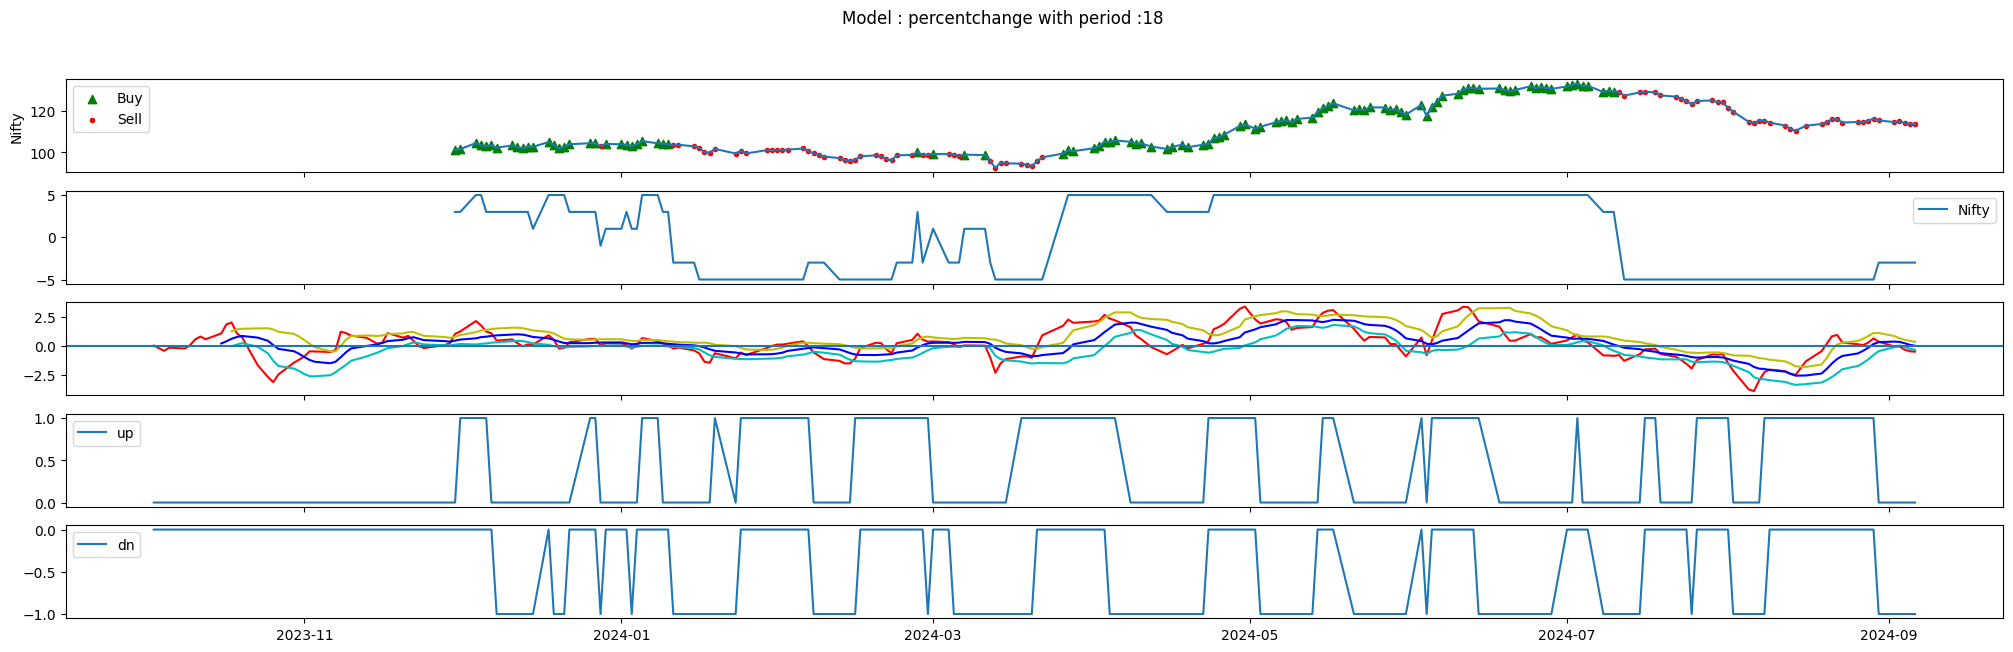

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(25,7),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(df[['bband']][:],color='r')
ax[2].plot(df[['avg',]][:],color='b')
ax[2].plot(df[['Upper Band',]][:],color='y')
ax[2].plot(df[['Lower Band']][:],color='c')
ax[2].axhline(y=0)
ax[3].plot(df['upsignal'] , label='up')
ax[4].plot(df['dnsignal'],label='dn')
ax[0].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[0].set_ylabel('Nifty')
ax[1].legend('ML Signal')
ax[1].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


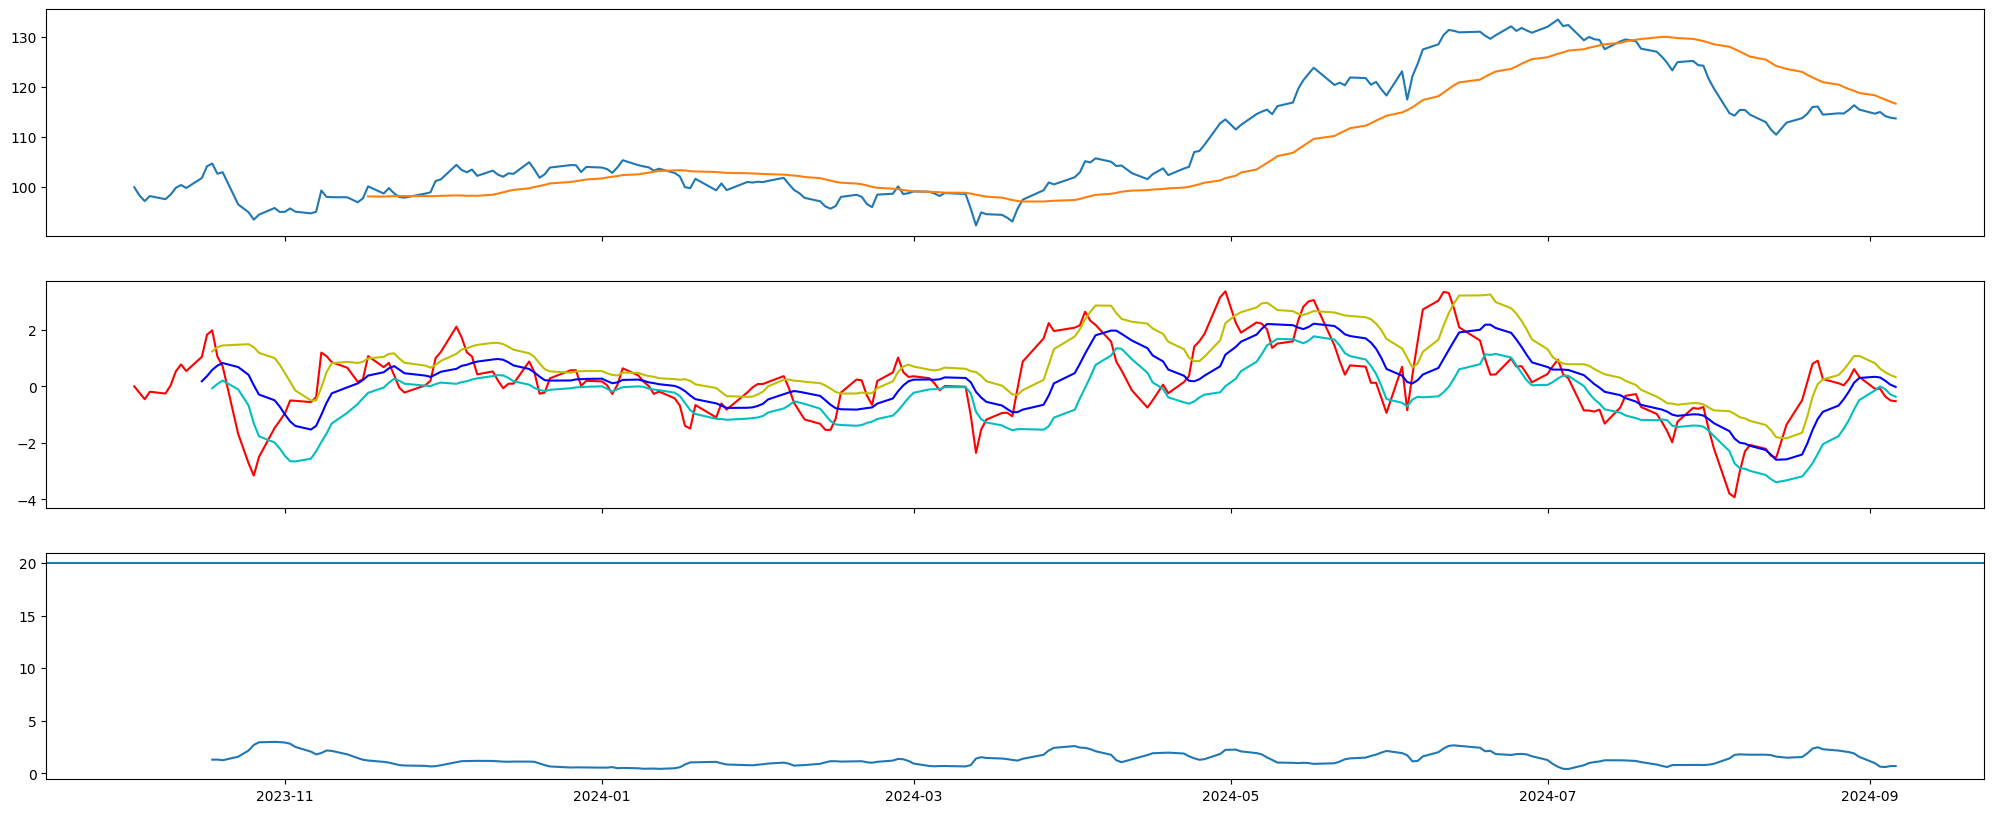

In [53]:
fig, ax = plt.subplots(3,1, figsize=(25,10),sharex=True)
ax[0].plot(df.loc[:, 'Close'])
ax[0].plot(df.loc[:,'Close'].rolling(window=32).mean())
ax[1].plot(df[['bband']][:],color='r')
ax[1].plot(df[['avg',]][:],color='b')
ax[1].plot(df[['Upper Band',]][:],color='y')
ax[1].plot(df[['Lower Band']][:],color='c')
ax[2].plot(df['Upper Band']-df['Lower Band'])
ax[2].axhline(y=20)
plt.show()

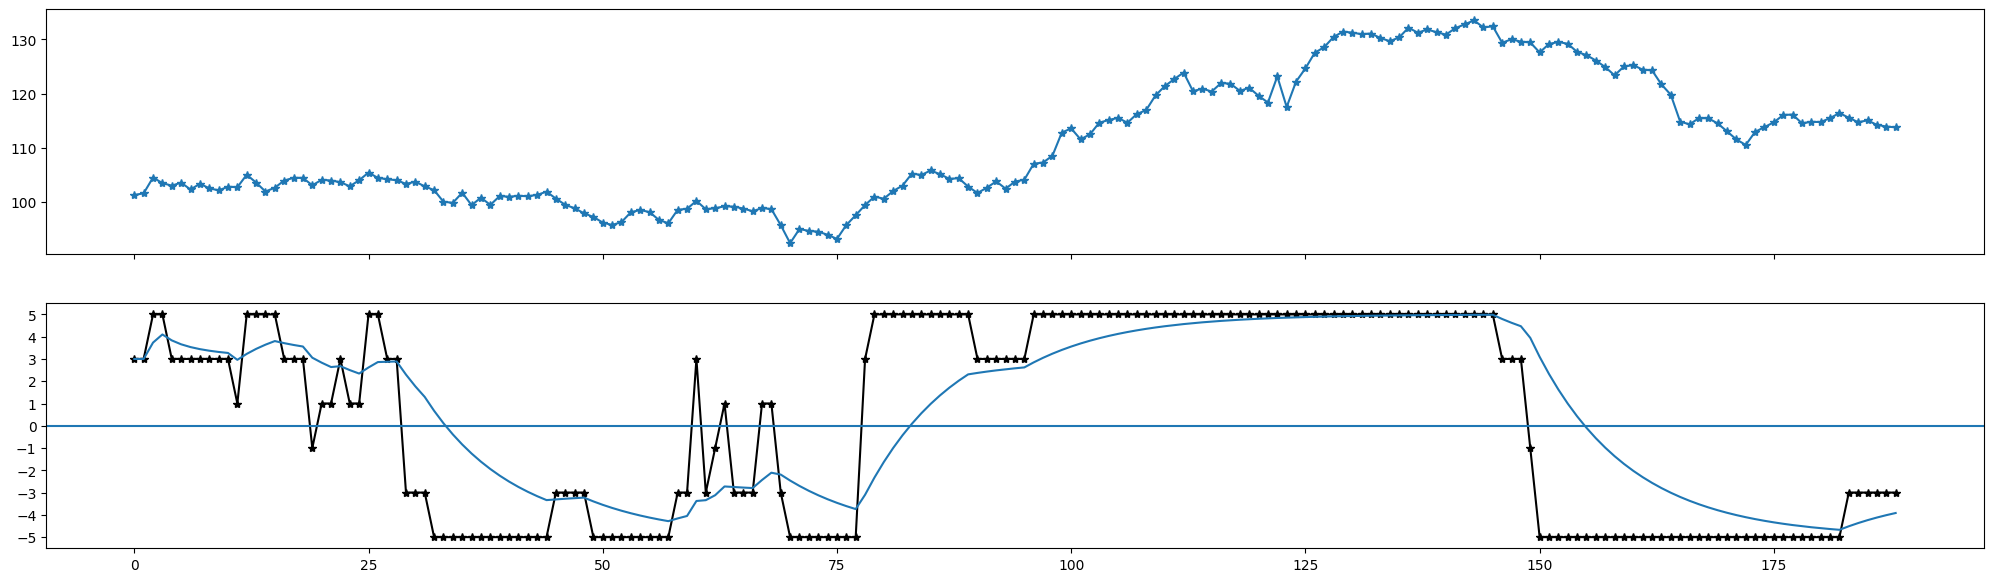

In [54]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)),'k*-')
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

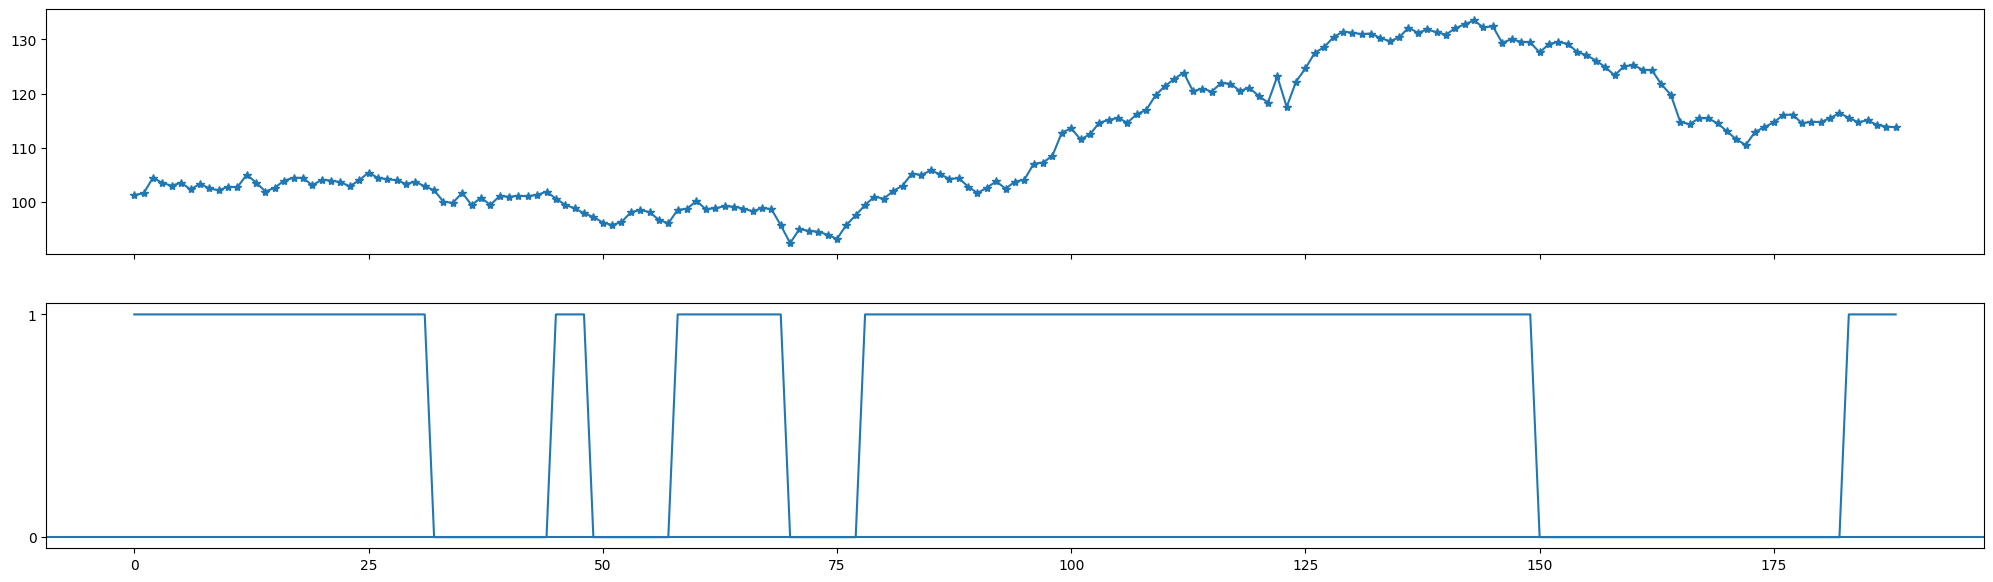

In [55]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(np.where(S_test_new.sum(axis=1)>-5,1,0)))
#ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

In [56]:
price_data_new['Position']=(np.where(S_test_new.sum(axis=1)>0,1,0))
# Calculate returns based on NEXT DAY's Open price
price_data_new['Returns'] = (price_data_new['Open'].shift(-1).pct_change()) * price_data_new['Position']


<ipython-input-56-23be911d0878>:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_data_new['Returns'] = (price_data_new['Open'].shift(-1).pct_change()) * price_data_new['Position']


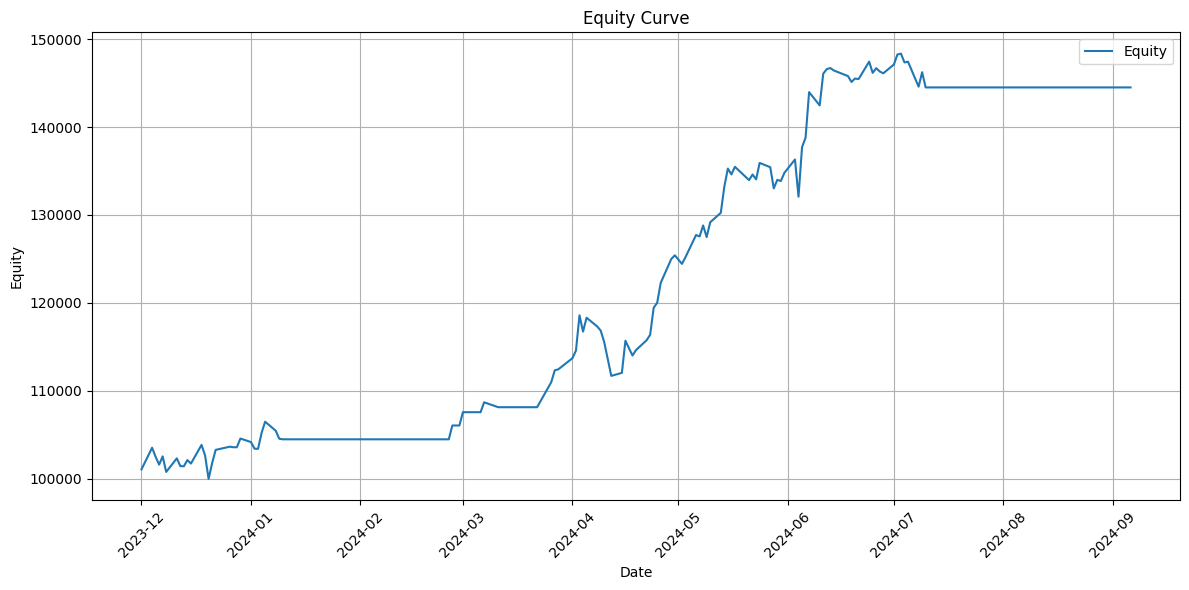

In [57]:
initial_capital = 100000
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Returns']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [58]:
def calculate_metrics(returns_series):
    """Calculates various trade metrics.

    Args:
        returns_series (pandas.Series): A Series of daily returns.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    annualized_return = (1 + returns_series).prod() ** (252 / len(returns_series)) - 1
    annualized_std = returns_series.std() * np.sqrt(252)

    sharpe_ratio = annualized_return / annualized_std

    cumulative_returns = (1 + returns_series).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = (1 + returns_series).cumprod().iloc[-1]
    num_years = len(returns_series) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown
    }

    return metrics

metrics = calculate_metrics(price_data_new['Returns'])

In [59]:
for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

CAGR: 0.6338
Annualized Return: 0.6338
Annualized Volatility: 0.1636
Sharpe Ratio: 3.8738
Calmar Ratio: 10.9045
Max Drawdown: -0.0581


In [60]:
from sklearn.metrics import classification_report
y_pred=np.sign(np.where(S_test_new.sum(axis=1)==0,1,S_test_new.sum(axis=1)))
y_true=price_data_new['Close'].transform(lambda x : np.sign(x.diff(days_out)))
y_true=y_true.dropna()
y_pred=y_pred[-len(y_true):]
print("Classification Report Averaging")
print(classification_report(y_true, y_pred))

Classification Report Averaging
              precision    recall  f1-score   support

        -1.0       0.92      0.91      0.91        87
         1.0       0.91      0.92      0.91        84

    accuracy                           0.91       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171



Precision

Downday (-1.0): Your model is correct about 62% of the time when predicting a downday.
Upday (1.0): Your model is very reliable, showing 92% precision in predicting updays.


Recall

Downday (-1.0): Your model identifies 83% of the actual downdays correctly.
Upday (1.0): Your model identifies 80% of the actual updays correctly.


F1-Score

Downday (-1.0): An F1-score of 0.71 indicates a decent balance between precision and recall for downdays.
Upday (1.0): A strong F1-score of 0.86 shows a good balance between precision and recall for updays.


Support: There are 12 downdays and 30 updays in the dataset.

Overall Assessment

Accuracy (0.81): The averaged model demonstrates a good overall accuracy of 81%.
Macro Average & Weighted Average: These provide a summary of the model's performance across both classes, considering the class imbalance in your dataset.